<a href="https://colab.research.google.com/github/abdipourasl/Alzheimer/blob/main/Fusion_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & models



In [ ]:
import os
import numpy as np
import math
import random
from collections import Counter
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model, clone_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, ConvLSTM2D,MaxPooling3D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, EfficientNetB2
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, Input
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/'

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    for part in parts:
        if part.startswith('subject'):
            return int(part.replace('subject', ''))
    return -1  # Return -1 if no numeric part is found

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

subject_folders, labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    subject_folder = os.path.join(data_dir, folder_name)
    subject_folders.append(subject_folder)

    if subject_num <= 36:
        labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        labels.append(1)  # HC group

subject_folders = np.array(subject_folders)
labels = np.array(labels)

print("Subject Folders:", subject_folders)
print("Labels:", labels)

Subject Folders: ['/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject1'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject2'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject3'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject4'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject5'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject6'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject7'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject8'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject9'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/sub

In [ ]:
def load_images_and_labels(subjects, labels):
    images, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        for filename in os.listdir(subject_folder):
            img_path = os.path.join(subject_folder, filename.decode())
            try:
                img = Image.open(img_path)

                width, height = img.size
                left = 100
                top = 70
                right = width - 200
                bottom = height - 65
                img = img.crop((left, top, right, bottom))

                img = img.resize((299, 299))
                img_array = img_to_array(img)
                img_array = img_array / 255.0

                images.append(img_array)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}, {e}")

    return np.array(images), np.array(labels_t)


In [ ]:
# def load_and_preprocess_data(subject_folders, labels):
#     train_subjects, test_subjects, train_labels, test_labels = train_test_split(subject_folders, labels, test_size=0.2, stratify=labels)

#     train_subjects, val_subjects, train_labels, val_labels = train_test_split(train_subjects, train_labels, test_size=0.1, stratify=train_labels)

#     train_images, train_labels_t = load_images_and_labels(train_subjects, train_labels)
#     val_images, val_labels_t = load_images_and_labels(val_subjects, val_labels)

#     test_image_counts_per_subject = [len(os.listdir(folder)) for folder in test_subjects]

#     test_images, test_labels_t = load_images_and_labels(test_subjects, test_labels)

#     return train_images, train_labels_t, val_images, val_labels_t, test_images, test_labels_t, test_subjects, test_image_counts_per_subject

def load_and_preprocess_data(subject_folders, labels):
    # Create dictionaries to categorize subjects into train, val, and test groups
    train_subjects_dict = {}
    val_subjects_dict = {}
    test_subjects_dict = {}

    for subject_folder, label in zip(subject_folders, labels):
        subject_num = extract_numeric_part(os.path.basename(subject_folder))
        if 3 <= subject_num <= 5 or 45 <= subject_num <= 47:
            val_subjects_dict[subject_folder] = label
        elif 6 <= subject_num <= 12 or 48 <= subject_num <= 53:
            test_subjects_dict[subject_folder] = label
        else:
            train_subjects_dict[subject_folder] = label

    # Extract subjects and labels for each group
    train_subjects = list(train_subjects_dict.keys())
    train_labels = [train_subjects_dict[subj] for subj in train_subjects]
    val_subjects = list(val_subjects_dict.keys())
    val_labels = [val_subjects_dict[subj] for subj in val_subjects]
    test_subjects = list(test_subjects_dict.keys())
    test_labels = [test_subjects_dict[subj] for subj in test_subjects]

    # Load images for each group
    train_images, train_labels_t = load_images_and_labels(train_subjects, train_labels)
    val_images, val_labels_t = load_images_and_labels(val_subjects, val_labels)
    test_images, test_labels_t = load_images_and_labels(test_subjects, test_labels)

    return train_images, train_labels_t, val_images, val_labels_t, test_images, test_labels_t, test_subjects, test_images


In [ ]:
def create_new_model(base_model):
    model = clone_model(base_model)

    for layer in model.layers:
        layer.trainable = False

    x = model.output
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(0.2)(x)
    x = Dense(256)(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = Dropout(0.2)(x)

    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [ ]:
# Define a custom callback to start saving checkpoints from epoch 30
class CustomCheckpoint(ModelCheckpoint):
    def __init__(self, start_epoch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

def train_and_evaluate_model(base_model, subject_folders, labels, num_epochs=50, num_iterations=5, model_name='model'):
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}:")

        model = create_new_model(base_model)

        train_images, train_labels_t, val_images, val_labels_t, test_images, test_labels_t, test_subjects, test_image_counts_per_subject = load_and_preprocess_data(subject_folders, labels)

        train_data = list(zip(train_images, train_labels_t))
        np.random.shuffle(train_data)
        train_images, train_labels_t = zip(*train_data)

        val_data = list(zip(val_images, val_labels_t))
        np.random.shuffle(val_data)
        val_images, val_labels_t = zip(*val_data)

        train_images, train_labels_t = np.array(train_images), np.array(train_labels_t)
        val_images, val_labels_t = np.array(val_images), np.array(val_labels_t)

        checkpoint_dir = '/content'
        os.makedirs(checkpoint_dir, exist_ok=True)

        local_checkpoint_filepath = os.path.join(checkpoint_dir, f"{model_name}_best_weights_iteration_{iteration + 1}.h5")
        drive_checkpoint_filepath = f'/content/drive/My Drive/{model_name}_best_weights_iteration_{iteration + 1}.h5'

        checkpoint_callback = CustomCheckpoint(
            start_epoch=30,
            filepath=local_checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        )

        class LearningRateLogger(Callback):
            def on_epoch_end(self, epoch, logs=None):
                logs = logs or {}
                logs['learning_rate'] = self.model.optimizer.learning_rate.numpy()
        lr_logger = LearningRateLogger()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False, start_from_epoch=30)

        history = model.fit(train_images, train_labels_t, epochs=num_epochs, batch_size=32, validation_data=(val_images, val_labels_t), callbacks=[checkpoint_callback, early_stopping, lr_logger], verbose=1)

        if os.path.exists(local_checkpoint_filepath):
            print(f"Best weights saved locally at: {local_checkpoint_filepath}")

            shutil.copy(local_checkpoint_filepath, drive_checkpoint_filepath)
            if os.path.exists(drive_checkpoint_filepath):
                print(f"Best weights also copied to Google Drive at: {drive_checkpoint_filepath}")
            else:
                print(f"Failed to copy best weights to Google Drive at: {drive_checkpoint_filepath}")
        else:
            print(f"Failed to save best weights locally at: {local_checkpoint_filepath}")

        model.load_weights(local_checkpoint_filepath)

        test_predictions = model.predict(test_images)
        test_predictions = (test_predictions > 0.5).astype(int)

        accuracy = accuracy_score(test_labels_t, test_predictions)
        precision = precision_score(test_labels_t, test_predictions)
        recall = recall_score(test_labels_t, test_predictions)
        f1 = f1_score(test_labels_t, test_predictions)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        print("ModelCheckpoint callback triggered and saved the best weights.")

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        file_name = f'{model_name}_accuracy_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        file_name = f'{model_name}_loss_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)

        cm = confusion_matrix(test_labels_t, test_predictions)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['AD', 'HC'], yticklabels=['AD', 'HC'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {model_name} - Iteration {iteration + 1}')
        file_name = f'{model_name}_confusion_matrix_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)


        print("\nPredictions for Each Subject's Images:")
        start_idx = 0
        for i, (subject_folder, num_images) in enumerate(zip(test_subjects, test_image_counts_per_subject)):
            end_idx = start_idx + num_images
            subject_images = test_images[start_idx:end_idx]
            subject_predictions = (model.predict(subject_images) > 0.5).astype(int)
            ad_count = sum(subject_predictions == 0)
            hc_count = sum(subject_predictions == 1)
            print(f"Subject {i + 1} ({subject_folder}):")
            print(f"AD count: {ad_count}, HC count: {hc_count}")
            start_idx = end_idx




    print("\nAverage Metrics:")
    print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")
    print(f"Average Precision: {np.mean(precision_list):.4f}")
    print(f"Average Recall: {np.mean(recall_list):.4f}")
    print(f"Average F1 Score: {np.mean(f1_list):.4f}")



# Train for Spectrogram on VGG, DenseNet, ResNet

## VGG16: 3 iterations

In [ ]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
model_name = 'vgg16_Central_Spectrogram'
train_and_evaluate_model(vgg16_base_model, subject_folders, labels, num_epochs=100, num_iterations=5, model_name=model_name)


Iteration 1:
Epoch 1/100
169/169 [==============================] - 117s 683ms/step - loss: 0.6969 - accuracy: 0.5299 - val_loss: 0.6889 - val_accuracy: 0.5814 - learning_rate: 0.0010
Epoch 2/100
169/169 [==============================] - 112s 662ms/step - loss: 0.6935 - accuracy: 0.5347 - val_loss: 0.7123 - val_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 3/100
169/169 [==============================] - 112s 662ms/step - loss: 0.6895 - accuracy: 0.5544 - val_loss: 0.7023 - val_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 4/100
169/169 [==============================] - 111s 658ms/step - loss: 0.6873 - accuracy: 0.5518 - val_loss: 0.6977 - val_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 5/100
169/169 [==============================] - 112s 665ms/step - loss: 0.6838 - accuracy: 0.5576 - val_loss: 0.6945 - val_accuracy: 0.4186 - learning_rate: 0.0010
Epoch 6/100
169/169 [==============================] - 111s 657ms/step - loss: 0.6608 - accuracy: 0.5918 - val_loss: 0.6806 - val_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:
2/2 [==============================] - 1s 329ms/step
Subject 1 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject61):
AD count: [25], HC count: [23]
4/4 [==============================] - 2s 438ms/step
Subject 2 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject62):
AD count: [2], HC count: [100]
6/6 [==============================] - 3s 542ms/step
Subject 3 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject64):
AD count: [2], HC count: [175]
3/3 [==============================] - 1s 425ms/step
Subject 4 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject45):
AD count: [64], HC count: [14]
5/5 [==============================] - 3s 475ms/step
Subject 5 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject43):
AD count: [129], HC count:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:
5/5 [==============================] - 3s 531ms/step
Subject 1 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject7):
AD count: [144], HC count: [0]
7/7 [==============================] - 4s 590ms/step
Subject 2 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject44):
AD count: [29], HC count: [190]
4/4 [==============================] - 2s 579ms/step
Subject 3 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject9):
AD count: [15], HC count: [108]
4/4 [==============================] - 2s 531ms/step
Subject 4 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject37):
AD count: [31], HC count: [83]
5/5 [==============================] - 2s 471ms/step
Subject 5 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject17):
AD count: [129], HC count:

In [ ]:
model_name = 'vgg16_Central_Spectrogram'
train_and_evaluate_model(vgg16_base_model, subject_folders, labels, num_epochs=100, num_iterations=5, model_name=model_name)


Iteration 1:
Epoch 1/100
176/176 [==============================] - 113s 635ms/step - loss: 0.6993 - accuracy: 0.5162 - val_loss: 0.7148 - val_accuracy: 0.4733 - learning_rate: 0.0010
Epoch 2/100
176/176 [==============================] - 109s 622ms/step - loss: 0.6815 - accuracy: 0.5652 - val_loss: 0.6824 - val_accuracy: 0.5281 - learning_rate: 0.0010
Epoch 3/100
176/176 [==============================] - 109s 621ms/step - loss: 0.6512 - accuracy: 0.6212 - val_loss: 0.6395 - val_accuracy: 0.6982 - learning_rate: 0.0010
Epoch 4/100
176/176 [==============================] - 110s 626ms/step - loss: 0.6110 - accuracy: 0.6667 - val_loss: 0.6161 - val_accuracy: 0.6543 - learning_rate: 0.0010
Epoch 5/100
176/176 [==============================] - 110s 625ms/step - loss: 0.5875 - accuracy: 0.6877 - val_loss: 0.6226 - val_accuracy: 0.6584 - learning_rate: 0.0010
Epoch 6/100
176/176 [==============================] - 109s 621ms/step - loss: 0.5391 - accuracy: 0.7237 - val_loss: 0.8167 - val_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:
2/2 [==============================] - 1s 307ms/step
Subject 1 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject61):
AD count: [32], HC count: [16]
3/3 [==============================] - 2s 505ms/step
Subject 2 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject20):
AD count: [89], HC count: [1]
4/4 [==============================] - 2s 413ms/step
Subject 3 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject53):
AD count: [2], HC count: [100]
6/6 [==============================] - 3s 487ms/step
Subject 4 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject34):
AD count: [90], HC count: [81]
3/3 [==============================] - 2s 502ms/step
Subject 5 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject51):
AD count: [0], HC count: [9

## ResNet50: 2

In [ ]:
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model_name = 'ResNet50_Central_Spectrogram'
train_and_evaluate_model(resnet50_base_model, subject_folders, labels, num_epochs=100, num_iterations=5, model_name=model_name)


Iteration 1:
Epoch 1/100
169/169 [==============================] - 113s 647ms/step - loss: 1.2143 - accuracy: 0.5119 - val_loss: 0.8040 - val_accuracy: 0.3606 - learning_rate: 0.0010
Epoch 2/100
169/169 [==============================] - 109s 645ms/step - loss: 0.9056 - accuracy: 0.5137 - val_loss: 0.8740 - val_accuracy: 0.3606 - learning_rate: 0.0010
Epoch 3/100
169/169 [==============================] - 110s 649ms/step - loss: 0.8341 - accuracy: 0.5317 - val_loss: 0.6372 - val_accuracy: 0.6394 - learning_rate: 0.0010
Epoch 4/100
169/169 [==============================] - 110s 651ms/step - loss: 0.7817 - accuracy: 0.5581 - val_loss: 0.6217 - val_accuracy: 0.6877 - learning_rate: 0.0010
Epoch 5/100
169/169 [==============================] - 108s 642ms/step - loss: 0.7043 - accuracy: 0.5924 - val_loss: 0.7620 - val_accuracy: 0.3606 - learning_rate: 0.0010
Epoch 6/100
169/169 [==============================] - 109s 643ms/step - loss: 0.6781 - accuracy: 0.6140 - val_loss: 0.8974 - val_a

## Densenet121: 3 iterations

In [ ]:
Dense_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model_name = 'Densenet121_Central_Spectrogram'
train_and_evaluate_model(Dense_base_model, subject_folders, labels, num_epochs=100, num_iterations=5, model_name=model_name)


Iteration 1:
Epoch 1/100
182/182 [==============================] - 131s 682ms/step - loss: 0.7957 - accuracy: 0.5292 - val_loss: 1.2115 - val_accuracy: 0.4836 - learning_rate: 0.0010
Epoch 2/100
182/182 [==============================] - 122s 669ms/step - loss: 0.7042 - accuracy: 0.5965 - val_loss: 0.8075 - val_accuracy: 0.3365 - learning_rate: 0.0010
Epoch 3/100
182/182 [==============================] - 117s 640ms/step - loss: 0.6474 - accuracy: 0.6443 - val_loss: 1.0543 - val_accuracy: 0.4836 - learning_rate: 0.0010
Epoch 4/100
182/182 [==============================] - 121s 665ms/step - loss: 0.6069 - accuracy: 0.6732 - val_loss: 0.9023 - val_accuracy: 0.2895 - learning_rate: 0.0010
Epoch 5/100
182/182 [==============================] - 121s 667ms/step - loss: 0.5916 - accuracy: 0.6816 - val_loss: 0.9474 - val_accuracy: 0.3005 - learning_rate: 0.0010
Epoch 6/100
182/182 [==============================] - 112s 616ms/step - loss: 0.5796 - accuracy: 0.6963 - val_loss: 0.8599 - val_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:
2/2 [==============================] - 1s 698ms/step
Subject 1 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject4):
AD count: [63], HC count: [0]
4/4 [==============================] - 2s 462ms/step
Subject 2 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject41):
AD count: [0], HC count: [105]
3/3 [==============================] - 2s 534ms/step
Subject 3 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject20):
AD count: [86], HC count: [4]
5/5 [==============================] - 3s 537ms/step
Subject 4 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject7):
AD count: [131], HC count: [13]
3/3 [==============================] - 2s 497ms/step
Subject 5 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject3):
AD count: [36], HC count: [45]

In [ ]:
model_name = 'Densenet121_Central_Spectrogram'
train_and_evaluate_model(Dense_base_model, subject_folders, labels, num_epochs=100, num_iterations=5, model_name=model_name)


Iteration 1:
Epoch 1/100
172/172 [==============================] - 125s 688ms/step - loss: 0.7272 - accuracy: 0.5824 - val_loss: 0.9178 - val_accuracy: 0.5862 - learning_rate: 0.0010
Epoch 2/100
172/172 [==============================] - 110s 641ms/step - loss: 0.6325 - accuracy: 0.6738 - val_loss: 0.7366 - val_accuracy: 0.4063 - learning_rate: 0.0010
Epoch 3/100
172/172 [==============================] - 107s 623ms/step - loss: 0.5508 - accuracy: 0.7327 - val_loss: 0.9936 - val_accuracy: 0.5723 - learning_rate: 0.0010
Epoch 4/100
172/172 [==============================] - 105s 612ms/step - loss: 0.5261 - accuracy: 0.7387 - val_loss: 0.6694 - val_accuracy: 0.6792 - learning_rate: 0.0010
Epoch 5/100
172/172 [==============================] - 103s 601ms/step - loss: 0.5292 - accuracy: 0.7354 - val_loss: 0.6527 - val_accuracy: 0.6314 - learning_rate: 0.0010
Epoch 6/100
172/172 [==============================] - 108s 628ms/step - loss: 0.4873 - accuracy: 0.7697 - val_loss: 0.7375 - val_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:
7/7 [==============================] - 4s 544ms/step
Subject 1 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject36):
AD count: [0], HC count: [198]
2/2 [==============================] - 1s 582ms/step
Subject 2 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject8):
AD count: [60], HC count: [0]
5/5 [==============================] - 2s 486ms/step
Subject 3 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject1):
AD count: [138], HC count: [0]
4/4 [==============================] - 2s 437ms/step
Subject 4 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject11):
AD count: [78], HC count: [30]
3/3 [==============================] - 2s 474ms/step
Subject 5 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject29):
AD count: [87], HC count: [0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:
4/4 [==============================] - 2s 600ms/step
Subject 1 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject59):
AD count: [31], HC count: [95]
5/5 [==============================] - 3s 511ms/step
Subject 2 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject1):
AD count: [138], HC count: [0]
4/4 [==============================] - 2s 399ms/step
Subject 3 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject5):
AD count: [107], HC count: [1]
4/4 [==============================] - 2s 497ms/step
Subject 4 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject53):
AD count: [29], HC count: [73]
2/2 [==============================] - 1s 473ms/step
Subject 5 (/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Central/subject26):
AD count: [57], HC count: [0

# Inception V3 for Spectrogram & Scalogram

In [ ]:
Inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_name = 'InceptionV3_Temporal_Spectrogram'
train_and_evaluate_model(Inception_base_model, subject_folders, labels, num_epochs=100, num_iterations=1, model_name=model_name)


Iteration 1:
Epoch 1/100
239/239 [==============================] - 123s 497ms/step - loss: 0.6908 - accuracy: 0.5433 - val_loss: 0.5994 - val_accuracy: 0.8791 - learning_rate: 0.0010
Epoch 2/100
239/239 [==============================] - 119s 499ms/step - loss: 0.6269 - accuracy: 0.6541 - val_loss: 0.3858 - val_accuracy: 0.8804 - learning_rate: 0.0010
Epoch 3/100
239/239 [==============================] - 118s 495ms/step - loss: 0.5760 - accuracy: 0.7029 - val_loss: 0.3827 - val_accuracy: 0.8315 - learning_rate: 0.0010
Epoch 4/100
239/239 [==============================] - 119s 496ms/step - loss: 0.5303 - accuracy: 0.7444 - val_loss: 0.3250 - val_accuracy: 0.8383 - learning_rate: 0.0010
Epoch 5/100
239/239 [==============================] - 120s 501ms/step - loss: 0.5205 - accuracy: 0.7504 - val_loss: 0.2559 - val_accuracy: 0.9280 - learning_rate: 0.0010
Epoch 6/100
239/239 [==============================] - 114s 476ms/step - loss: 0.4828 - accuracy: 0.7768 - val_loss: 0.3338 - val_a

In [ ]:
data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/'

def extract_numeric_part(folder_name):
    return int(folder_name.split('_')[-1])

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

subject_folders, labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    subject_folder = os.path.join(data_dir, folder_name)
    subject_folders.append(subject_folder)

    if subject_num <= 36:
        labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        labels.append(1)  # HC group

subject_folders = np.array(subject_folders)
labels = np.array(labels)

print("Subject Folders:", subject_folders)
print("Labels:", labels)

In [ ]:
Inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
model_name = 'InceptionV3_Temporal_Scalogram'
train_and_evaluate_model(Inception_base_model, subject_folders, labels, num_epochs=100, num_iterations=1, model_name=model_name)

# Fusion Model

## Inception V3 for Spectrogram & Scalogram


In [ ]:
import os
import numpy as np
import math
import random
from collections import Counter
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model, clone_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, ConvLSTM2D,MaxPooling3D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, EfficientNetB2
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, Input
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Spectrogram

In [ ]:
data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Temporal/'

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    for part in parts:
        if part.startswith('subject'):
            return int(part.replace('subject', ''))
    return -1  # Return -1 if no numeric part is found

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

Spectrogram_subject_folders, Spectrogram_labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    Spectrogram_subject_folder = os.path.join(data_dir, folder_name)
    Spectrogram_subject_folders.append(Spectrogram_subject_folder)

    if subject_num <= 36:
        Spectrogram_labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        Spectrogram_labels.append(1)  # HC group

Spectrogram_subject_folders = np.array(Spectrogram_subject_folders)
Spectrogram_labels = np.array(Spectrogram_labels)

print("Subject Folders:", Spectrogram_subject_folders)
print("Labels:", Spectrogram_labels)

Subject Folders: ['/content/drive/MyDrive/Alzheimer/Spectrogram Images/Temporal/subject21']
Labels: [0]


In [ ]:
import json
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import model_from_json

# Define a custom callback to start saving checkpoints from epoch 15
class CustomCheckpoint(ModelCheckpoint):
    def __init__(self, start_epoch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

def train_and_evaluate_model(base_model, Spectrogram_subject_folders, Spectrogram_labels, num_epochs=50, num_iterations=5, model_name='model'):
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}:")

        model = create_new_model(base_model)

        train_images, train_labels_t, val_images, val_labels_t, test_images, test_labels_t, test_subjects, test_image_counts_per_subject = load_and_preprocess_data(Spectrogram_subject_folders, Spectrogram_labels)

        train_data = list(zip(train_images, train_labels_t))
        np.random.shuffle(train_data)
        train_images, train_labels_t = zip(*train_data)

        val_data = list(zip(val_images, val_labels_t))
        np.random.shuffle(val_data)
        val_images, val_labels_t = zip(*val_data)

        train_images, train_labels_t = np.array(train_images), np.array(train_labels_t)
        val_images, val_labels_t = np.array(val_images), np.array(val_labels_t)

        checkpoint_dir = '/content'
        os.makedirs(checkpoint_dir, exist_ok=True)

        local_checkpoint_filepath = os.path.join(checkpoint_dir, f"{model_name}_best_weights_iteration_{iteration + 1}.h5")
        drive_checkpoint_filepath = f'/content/drive/My Drive/{model_name}_best_weights_iteration_{iteration + 1}.h5'

        checkpoint_callback = CustomCheckpoint(
            start_epoch=15,
            filepath=local_checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        )

        class LearningRateLogger(Callback):
            def on_epoch_end(self, epoch, logs=None):
                logs = logs or {}
                logs['learning_rate'] = self.model.optimizer.learning_rate.numpy()
        lr_logger = LearningRateLogger()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False, start_from_epoch=15)

        history = model.fit(train_images, train_labels_t, epochs=num_epochs, batch_size=32, validation_data=(val_images, val_labels_t), callbacks=[checkpoint_callback, early_stopping, lr_logger], verbose=1)

        # Save the model architecture as JSON
        model_json = model.to_json()
        json_filepath = os.path.join(checkpoint_dir, f"{model_name}_iteration_{iteration + 1}.json")
        with open(json_filepath, "w") as json_file:
            json_file.write(model_json)
        shutil.copy(json_filepath, f'/content/drive/My Drive/{model_name}_iteration_{iteration + 1}.json')

        # Save the model weights
        if os.path.exists(local_checkpoint_filepath):
            print(f"Best weights saved locally at: {local_checkpoint_filepath}")
            shutil.copy(local_checkpoint_filepath, drive_checkpoint_filepath)
            if os.path.exists(drive_checkpoint_filepath):
                print(f"Best weights also copied to Google Drive at: {drive_checkpoint_filepath}")
            else:
                print(f"Failed to copy best weights to Google Drive at: {drive_checkpoint_filepath}")
        else:
            print(f"Failed to save best weights locally at: {local_checkpoint_filepath}")

        # Load the model architecture and weights for evaluation
        with open(json_filepath, "r") as json_file:
            loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(local_checkpoint_filepath)

        test_predictions = loaded_model.predict(test_images)
        test_predictions = (test_predictions > 0.5).astype(int)

        accuracy = accuracy_score(test_labels_t, test_predictions)
        precision = precision_score(test_labels_t, test_predictions)
        recall = recall_score(test_labels_t, test_predictions)
        f1 = f1_score(test_labels_t, test_predictions)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        file_name = f'{model_name}_accuracy_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        file_name = f'{model_name}_loss_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)

        cm = confusion_matrix(test_labels_t, test_predictions)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['AD', 'HC'], yticklabels=['AD', 'HC'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {model_name} - Iteration {iteration + 1}')
        file_name = f'{model_name}_confusion_matrix_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)


        print("\nPredictions for Each Subject's Images:")
        start_idx = 0
        for i, (subject_folder, num_images) in enumerate(zip(test_subjects, test_image_counts_per_subject)):
            end_idx = start_idx + num_images
            subject_images = test_images[start_idx:end_idx]
            subject_predictions = (loaded_model.predict(subject_images) > 0.5).astype(int)
            ad_count = sum(subject_predictions == 0)
            hc_count = sum(subject_predictions == 1)
            print(f"Subject {i + 1} ({subject_folder}):")
            print(f"AD count: {ad_count}, HC count: {hc_count}")
            start_idx = end_idx

    print("\nAverage Metrics:")
    print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")
    print(f"Average Precision: {np.mean(precision_list):.4f}")
    print(f"Average Recall: {np.mean(recall_list):.4f}")
    print(f"Average F1 Score: {np.mean(f1_list):.4f}")


In [ ]:
Inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_name = 'InceptionV3_Temporal_Spectrogram'
train_and_evaluate_model(Inception_base_model, Spectrogram_subject_folders, Spectrogram_labels, num_epochs=100, num_iterations=1, model_name=model_name)


Iteration 1:
Epoch 1/100
239/239 [==============================] - 120s 485ms/step - loss: 0.6972 - accuracy: 0.5315 - val_loss: 0.6542 - val_accuracy: 0.5476 - learning_rate: 0.0010
Epoch 2/100
239/239 [==============================] - 115s 481ms/step - loss: 0.6541 - accuracy: 0.6199 - val_loss: 0.4300 - val_accuracy: 0.8546 - learning_rate: 0.0010
Epoch 3/100
239/239 [==============================] - 117s 489ms/step - loss: 0.5992 - accuracy: 0.6836 - val_loss: 0.3522 - val_accuracy: 0.9022 - learning_rate: 0.0010
Epoch 4/100
239/239 [==============================] - 117s 488ms/step - loss: 0.5745 - accuracy: 0.7047 - val_loss: 0.3512 - val_accuracy: 0.9348 - learning_rate: 0.0010
Epoch 5/100
239/239 [==============================] - 114s 477ms/step - loss: 0.5102 - accuracy: 0.7484 - val_loss: 0.3166 - val_accuracy: 0.9103 - learning_rate: 0.0010
Epoch 6/100
239/239 [==============================] - 118s 492ms/step - loss: 0.4728 - accuracy: 0.7764 - val_loss: 0.2411 - val_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Predictions for Each Subject's Images:


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# Function to save model architecture
def save_model_architecture(model, model_name):
    model_json = model.to_json()
    with open(f"{model_name}_architecture.json", "w") as json_file:
        json_file.write(model_json)

# Function to load model architecture
def load_model_architecture(model_name):
    with open(f"{model_name}_architecture.json", "r") as json_file:
        model_json = json_file.read()
    return model_from_json(model_json)

# Save base model architecture
base_model = create_new_model(base_model)
save_model_architecture(base_model, 'base_model')

# Load base model architecture
base_model = load_model_architecture('base_model')


### Scalogram

In [ ]:
data_dir = '/content/drive/MyDrive/Alzheimer/Scalogram Images/Temporal/'

def extract_numeric_part(folder_name):
    return int(folder_name.split('_')[-1])

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

Scalogram_subject_folders, Scalogram_labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    Scalogram_subject_folder = os.path.join(data_dir, folder_name)
    Scalogram_subject_folders.append(Scalogram_subject_folder)

    if subject_num <= 36:
        Scalogram_labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        Scalogram_labels.append(1)  # HC group

Scalogram_subject_folders = np.array(Scalogram_subject_folders)
Scalogram_labels = np.array(Scalogram_labels)

print("Subject Folders:", Scalogram_subject_folders)
print("Labels:", Scalogram_labels)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Alzheimer/Scalogram Images/Temporal/'

In [ ]:
import json
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import model_from_json

# Define a custom callback to start saving checkpoints from epoch 15
class CustomCheckpoint(ModelCheckpoint):
    def __init__(self, start_epoch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

def train_and_evaluate_model(base_model, Scalogram_subject_folders, Scalogram_labels, num_epochs=50, num_iterations=1, model_name='model'):
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}:")

        model = create_new_model(base_model)

        train_images, train_labels_t, val_images, val_labels_t, test_images, test_labels_t, test_subjects, test_image_counts_per_subject = load_and_preprocess_data(Scalogram_subject_folders, Scalogram_labels)

        train_data = list(zip(train_images, train_labels_t))
        np.random.shuffle(train_data)
        train_images, train_labels_t = zip(*train_data)

        val_data = list(zip(val_images, val_labels_t))
        np.random.shuffle(val_data)
        val_images, val_labels_t = zip(*val_data)

        train_images, train_labels_t = np.array(train_images), np.array(train_labels_t)
        val_images, val_labels_t = np.array(val_images), np.array(val_labels_t)

        checkpoint_dir = '/content'
        os.makedirs(checkpoint_dir, exist_ok=True)

        local_checkpoint_filepath = os.path.join(checkpoint_dir, f"{model_name}_best_weights_iteration_{iteration + 1}.h5")
        drive_checkpoint_filepath = f'/content/drive/My Drive/{model_name}_best_weights_iteration_{iteration + 1}.h5'

        checkpoint_callback = CustomCheckpoint(
            start_epoch=15,
            filepath=local_checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        )

        class LearningRateLogger(Callback):
            def on_epoch_end(self, epoch, logs=None):
                logs = logs or {}
                logs['learning_rate'] = self.model.optimizer.learning_rate.numpy()
        lr_logger = LearningRateLogger()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False, start_from_epoch=15)

        history = model.fit(train_images, train_labels_t, epochs=num_epochs, batch_size=32, validation_data=(val_images, val_labels_t), callbacks=[checkpoint_callback, early_stopping, lr_logger], verbose=1)

        # Save the model architecture as JSON
        model_json = model.to_json()
        json_filepath = os.path.join(checkpoint_dir, f"{model_name}_iteration_{iteration + 1}.json")
        with open(json_filepath, "w") as json_file:
            json_file.write(model_json)
        shutil.copy(json_filepath, f'/content/drive/My Drive/{model_name}_iteration_{iteration + 1}.json')

        # Save the model weights
        if os.path.exists(local_checkpoint_filepath):
            print(f"Best weights saved locally at: {local_checkpoint_filepath}")
            shutil.copy(local_checkpoint_filepath, drive_checkpoint_filepath)
            if os.path.exists(drive_checkpoint_filepath):
                print(f"Best weights also copied to Google Drive at: {drive_checkpoint_filepath}")
            else:
                print(f"Failed to copy best weights to Google Drive at: {drive_checkpoint_filepath}")
        else:
            print(f"Failed to save best weights locally at: {local_checkpoint_filepath}")

        # Load the model architecture and weights for evaluation
        with open(json_filepath, "r") as json_file:
            loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(local_checkpoint_filepath)

        test_predictions = loaded_model.predict(test_images)
        test_predictions = (test_predictions > 0.5).astype(int)

        accuracy = accuracy_score(test_labels_t, test_predictions)
        precision = precision_score(test_labels_t, test_predictions)
        recall = recall_score(test_labels_t, test_predictions)
        f1 = f1_score(test_labels_t, test_predictions)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        file_name = f'{model_name}_accuracy_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        file_name = f'{model_name}_loss_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)

        cm = confusion_matrix(test_labels_t, test_predictions)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['AD', 'HC'], yticklabels=['AD', 'HC'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {model_name} - Iteration {iteration + 1}')
        file_name = f'{model_name}_confusion_matrix_iteration_{iteration + 1}.png'
        plt.savefig(file_name)
        plt.close()
        files.download(file_name)


        print("\nPredictions for Each Subject's Images:")
        start_idx = 0
        for i, (subject_folder, num_images) in enumerate(zip(test_subjects, test_image_counts_per_subject)):
            end_idx = start_idx + num_images
            subject_images = test_images[start_idx:end_idx]
            subject_predictions = (loaded_model.predict(subject_images) > 0.5).astype(int)
            ad_count = sum(subject_predictions == 0)
            hc_count = sum(subject_predictions == 1)
            print(f"Subject {i + 1} ({subject_folder}):")
            print(f"AD count: {ad_count}, HC count: {hc_count}")
            start_idx = end_idx

    print("\nAverage Metrics:")
    print(f"Average Accuracy: {np.mean(accuracy_list):.4f}")
    print(f"Average Precision: {np.mean(precision_list):.4f}")
    print(f"Average Recall: {np.mean(recall_list):.4f}")
    print(f"Average F1 Score: {np.mean(f1_list):.4f}")


In [ ]:
Inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_name = 'InceptionV3_Temporal_Scalogram'
train_and_evaluate_model(Inception_base_model, Scalogram_subject_folders, Scalogram_labels, num_epochs=100, num_iterations=1, model_name=model_name)


Iteration 1:


KeyboardInterrupt: 

## Complete Model

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, clone_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from google.colab import files, drive

drive.mount('/content/drive')

# Function to extract numeric part of the folder name
def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    for part in parts:
        if part.startswith('subject'):
            return int(part.replace('subject', ''))
    return -1

# Load images and labels
def load_images_and_labels(subjects, labels):
    images, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        subject_folder = str(subject_folder)  # Ensure it's a string
        for filename in os.listdir(subject_folder):
            img_path = os.path.join(subject_folder, str(filename))  # Ensure filename is a string
            try:
                img = Image.open(img_path)
                width, height = img.size
                left, top, right, bottom = 100, 70, width - 200, height - 65
                img = img.crop((left, top, right, bottom))
                img = img.resize((299, 299))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}, {e}")
    return np.array(images), np.array(labels_t)

# Data loading and preprocessing
def load_and_preprocess_data(subject_folders, labels):
    train_subjects, val_subjects, test_subjects = {}, {}, {}
    for subject_folder, label in zip(subject_folders, labels):
        subject_num = extract_numeric_part(os.path.basename(subject_folder))
        if 3 <= subject_num <= 5 or 45 <= subject_num <= 47:
            val_subjects[subject_folder] = label
        elif 6 <= subject_num <= 12 or 48 <= subject_num <= 53:
            test_subjects[subject_folder] = label
        else:
            train_subjects[subject_folder] = label

    def split_data(data):
        subjects = list(data.keys())
        labels = [data[subj] for subj in subjects]
        images, labels_t = load_images_and_labels(subjects, labels)
        return images, np.array(labels_t)

    train_images, train_labels = split_data(train_subjects)
    val_images, val_labels = split_data(val_subjects)
    test_images, test_labels = split_data(test_subjects)

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

# Model creation
def create_new_model(base_model):
    model = clone_model(base_model)
    for layer in model.layers:
        layer.trainable = False
    x = model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Paths for Spectrogram and Scalogram data
spectrogram_data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/'
scalogram_data_dir = '/content/drive/MyDrive/Alzheimer/Scalogram Images/Temporal/'

# Load subject folders and labels
def load_subjects_and_labels(data_dir, group_ranges):
    folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)
    subject_folders, labels = [], []
    for folder_name in folders:
        subject_num = extract_numeric_part(folder_name)
        subject_folder = os.path.join(data_dir, folder_name)
        subject_folders.append(subject_folder)
        if group_ranges[0] <= subject_num <= group_ranges[1]:
            labels.append(0)  # AD group
        elif group_ranges[2] <= subject_num <= group_ranges[3]:
            labels.append(1)  # HC group
    return np.array(subject_folders), np.array(labels)

Spectrogram_subject_folders, Spectrogram_labels = load_subjects_and_labels(spectrogram_data_dir, (1, 36, 37, 65))
Scalogram_subject_folders, Scalogram_labels = load_subjects_and_labels(scalogram_data_dir, (1, 36, 37, 65))

# Custom checkpoint to start saving from epoch 15
class CustomCheckpoint(ModelCheckpoint):
    def __init__(self, start_epoch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

# Function to train and evaluate model
def train_and_evaluate_model(base_model, subject_folders, labels, model_name, num_epochs=50, num_iterations=1):
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}:")
        model = create_new_model(base_model)
        train_images, train_labels, val_images, val_labels, test_images, test_labels = load_and_preprocess_data(subject_folders, labels)
        train_data = list(zip(train_images, train_labels))
        val_data = list(zip(val_images, val_labels))
        np.random.shuffle(train_data)
        np.random.shuffle(val_data)
        train_images, train_labels = zip(*train_data)
        val_images, val_labels = zip(*val_data)
        train_images, train_labels = np.array(train_images), np.array(train_labels)
        val_images, val_labels = np.array(val_images), np.array(val_labels)
        checkpoint_dir = '/content'
        os.makedirs(checkpoint_dir, exist_ok=True)
        local_checkpoint_filepath = os.path.join(checkpoint_dir, f"{model_name}_best_weights_iteration_{iteration + 1}.h5")
        drive_checkpoint_filepath = f'/content/drive/My Drive/{model_name}_best_weights_iteration_{iteration + 1}.h5'
        checkpoint_callback = CustomCheckpoint(start_epoch=15, filepath=local_checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=False, start_from_epoch=15)

        history = model.fit(train_images, train_labels, epochs=num_epochs, batch_size=32, validation_data=(val_images, val_labels), callbacks=[checkpoint_callback, early_stopping], verbose=1)

        # Save model architecture as JSON
        model_json = model.to_json()
        json_filepath = os.path.join(checkpoint_dir, f"{model_name}_iteration_{iteration + 1}.json")
        with open(json_filepath, "w") as json_file:
            json_file.write(model_json)
        shutil.copy(json_filepath, f'/content/drive/My Drive/{model_name}_iteration_{iteration + 1}.json')

        # Save model weights
        if os.path.exists(local_checkpoint_filepath):
            shutil.copy(local_checkpoint_filepath, drive_checkpoint_filepath)
        with open(json_filepath, "r") as json_file:
            loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(local_checkpoint_filepath)
        test_predictions = (loaded_model.predict(test_images) > 0.5).astype(int)
        accuracy = accuracy_score(test_labels, test_predictions)
        precision = precision_score(test_labels, test_predictions)
        recall = recall_score(test_labels, test_predictions)
        f1 = f1_score(test_labels, test_predictions)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Confusion matrix
        cm = confusion_matrix(test_labels, test_predictions)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {model_name} - Iteration {iteration + 1}')
        plt.show()

    mean_accuracy = np.mean(accuracy_list)
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)
    mean_f1 = np.mean(f1_list)
    std_accuracy = np.std(accuracy_list)
    std_precision = np.std(precision_list)
    std_recall = np.std(recall_list)
    std_f1 = np.std(f1_list)

    print(f"Average Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average Precision: {mean_precision:.4f} ± {std_precision:.4f}")
    print(f"Average Recall: {mean_recall:.4f} ± {std_recall:.4f}")
    print(f"Average F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")

# Define base models for Spectrogram and Scalogram
base_model_spectrogram = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_scalogram = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Train and evaluate models
train_and_evaluate_model(base_model_spectrogram, Spectrogram_subject_folders, Spectrogram_labels, "Spectrogram_Model", num_epochs=50, num_iterations=1)
train_and_evaluate_model(base_model_scalogram, Scalogram_subject_folders, Scalogram_labels, "Scalogram_Model", num_epochs=50, num_iterations=1)

# Fusion model training
def create_fusion_model(spectrogram_model, scalogram_model):
    for layer in spectrogram_model.layers:
        layer.trainable = False
    for layer in scalogram_model.layers:
        layer.trainable = False

    combined_input = Input(shape=(299, 299, 3))
    spectrogram_features = spectrogram_model(combined_input)
    scalogram_features = scalogram_model(combined_input)

    combined_features = tf.keras.layers.Concatenate()([spectrogram_features, scalogram_features])
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[spectrogram_model.input, scalogram_model.input], outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

fusion_model = create_fusion_model(base_model_spectrogram, base_model_scalogram)
fusion_model.summary()

# Training fusion model with combined dataset
def load_combined_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    # Ensure folders and labels match
    assert np.array_equal(spectrogram_labels, scalogram_labels), "Labels do not match."

    spectrogram_images, _ = load_images_and_labels(spectrogram_folders, spectrogram_labels)
    scalogram_images, _ = load_images_and_labels(scalogram_folders, scalogram_labels)

    return spectrogram_images, scalogram_images, spectrogram_labels

spectrogram_images, scalogram_images, combined_labels = load_combined_data(Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels)

# Train the fusion model
checkpoint_dir = '/content'
os.makedirs(checkpoint_dir, exist_ok=True)
fusion_checkpoint_filepath = os.path.join(checkpoint_dir, "Fusion_Model_best_weights.h5")
fusion_drive_checkpoint_filepath = '/content/drive/My Drive/Fusion_Model_best_weights.h5'
fusion_checkpoint_callback = CustomCheckpoint(start_epoch=15, filepath=fusion_checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=False, start_from_epoch=15)

history = fusion_model.fit([spectrogram_images, scalogram_images], combined_labels, epochs=50, batch_size=32, validation_split=0.2, callbacks=[fusion_checkpoint_callback, early_stopping], verbose=1)

# Save fusion model architecture and weights
fusion_model_json = fusion_model.to_json()
json_filepath = os.path.join(checkpoint_dir, "Fusion_Model.json")
with open(json_filepath, "w") as json_file:
    json_file.write(fusion_model_json)
shutil.copy(json_filepath, '/content/drive/My Drive/Fusion_Model.json')

if os.path.exists(fusion_checkpoint_filepath):
    shutil.copy(fusion_checkpoint_filepath, fusion_drive_checkpoint_filepath)

# Load best weights
fusion_model.load_weights(fusion_checkpoint_filepath)

# Evaluate on test data
test_images, test_labels = load_combined_data(test_subjects, test_labels, test_subjects, test_labels)
test_predictions = (fusion_model.predict([test_images, test_images]) > 0.5).astype(int)

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print(f"Fusion Model Test Accuracy: {accuracy:.4f}")
print(f"Fusion Model Test Precision: {precision:.4f}")
print(f"Fusion Model Test Recall: {recall:.4f}")
print(f"Fusion Model Test F1 Score: {f1:.4f}")

# Confusion matrix for fusion model
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

In [ ]:
model.summary()

## Use pretrained weights: Temporal

In [ ]:
data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal'

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    for part in parts:
        if part.startswith('subject'):
            return int(part.replace('subject', ''))
    return -1  # Return -1 if no numeric part is found

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

Spectrogram_subject_folders, Spectrogram_labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    Spectrogram_subject_folder = os.path.join(data_dir, folder_name)
    Spectrogram_subject_folders.append(Spectrogram_subject_folder)

    if subject_num <= 36:
        Spectrogram_labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        Spectrogram_labels.append(1)  # HC group

Spectrogram_subject_folders = np.array(Spectrogram_subject_folders)
Spectrogram_labels = np.array(Spectrogram_labels)

print("Spectrogram Subject Folders:", Spectrogram_subject_folders)
print("Labels:", Spectrogram_labels)

Spectrogram Subject Folders: ['/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject1'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject2'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject3'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject4'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject5'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject6'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject7'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject8'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/subject9'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/

In [ ]:
# data_dir = '/content/drive/MyDrive/Alzheimer/Scalogram Images/Temporal/'
!unrar x '/content/drive/MyDrive/Alzheimer/Final_1Hz/Temporal.rar'
data_dir = '/content/Temporal'
def extract_numeric_part(folder_name):
    return int(folder_name.split('_')[-1])

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

Scalogram_subject_folders, Scalogram_labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    Scalogram_subject_folder = os.path.join(data_dir, folder_name)
    Scalogram_subject_folders.append(Scalogram_subject_folder)

    if subject_num <= 36:
        Scalogram_labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        Scalogram_labels.append(1)  # HC group

Scalogram_subject_folders = np.array(Scalogram_subject_folders)
Scalogram_labels = np.array(Scalogram_labels)

print("Scalogram Subject Folders:", Scalogram_subject_folders)
print("Labels:", Scalogram_labels)

Streaming output truncated to the last 5000 lines.
Extracting  Temporal/Subject_40/Subject_40_Channel_14_Epoch_6.jpg         51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_14_Epoch_7.jpg         51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_14_Epoch_8.jpg         51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_14_Epoch_9.jpg         51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_15_Epoch_1.jpg         51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_15_Epoch_10.jpg        51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_15_Epoch_11.jpg        51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_15_Epoch_12.jpg        51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_15_Epoch_13.jpg        51%  OK 
Extracting  Temporal/Subject_40/Subject_40_Channel_15_Epoch_14.jpg        51%  OK 
Extracting  Temporal/Subject_

### Group 1

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
from google.colab import drive

drive.mount('/content/drive')

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    if len(parts) > 1:
        return int(parts[-1].replace('Subject', '').replace('subject', ''))
    else:
        return int(folder_name.replace('Subject', '').replace('subject', ''))

def load_images_and_labels(subjects, labels):
    images, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        subject_folder = str(subject_folder)
        for filename in os.listdir(subject_folder):
            img_path = os.path.join(subject_folder, str(filename))
            try:
                img = Image.open(img_path)
                width, height = img.size
                left, top, right, bottom = 100, 70, width - 200, height - 65
                img = img.crop((left, top, right, bottom))
                img = img.resize((299, 299))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}, {e}")
    return np.array(images), np.array(labels_t)

def load_and_preprocess_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    train_spectrogram_subjects, val_spectrogram_subjects, test_spectrogram_subjects = {}, {}, {}
    train_scalogram_subjects, val_scalogram_subjects, test_scalogram_subjects = {}, {}, {}
    ignore_subject = 'Subject_21'

    for spectrogram_subject_folder, spectrogram_label in zip(spectrogram_folders, spectrogram_labels):
        spectrogram_subject_num = extract_numeric_part(os.path.basename(spectrogram_subject_folder))
        if 3 <= spectrogram_subject_num <= 5 or 45 <= spectrogram_subject_num <= 47:
            val_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        elif 6 <= spectrogram_subject_num <= 12 or 48 <= spectrogram_subject_num <= 53:
            test_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        else:
            train_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label

    for scalogram_subject_folder, scalogram_label in zip(scalogram_folders, scalogram_labels):
        # if os.path.basename(scalogram_subject_folder) == ignore_subject:
        #     continue
        scalogram_subject_num = extract_numeric_part(os.path.basename(scalogram_subject_folder))
        if 3 <= scalogram_subject_num <= 5 or 45 <= scalogram_subject_num <= 47:
            val_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        elif 6 <= scalogram_subject_num <= 12 or 48 <= scalogram_subject_num <= 53:
            test_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        else:
            train_scalogram_subjects[scalogram_subject_folder] = scalogram_label

    def split_data(data):
        subjects = list(data.keys())
        labels = [data[subj] for subj in subjects]
        images, labels_t = load_images_and_labels(subjects, labels)
        return images, np.array(labels_t)

    train_spectrogram_images, train_spectrogram_labels = split_data(train_spectrogram_subjects)
    val_spectrogram_images, val_spectrogram_labels = split_data(val_spectrogram_subjects)
    test_spectrogram_images, test_spectrogram_labels = split_data(test_spectrogram_subjects)

    train_scalogram_images, train_scalogram_labels = split_data(train_scalogram_subjects)
    val_scalogram_images, val_scalogram_labels = split_data(val_scalogram_subjects)
    test_scalogram_images, test_scalogram_labels = split_data(test_scalogram_subjects)

    return (
        train_spectrogram_images, train_spectrogram_labels,
        val_spectrogram_images, val_spectrogram_labels,
        test_spectrogram_images, test_spectrogram_labels,
        train_scalogram_images, train_scalogram_labels,
        val_scalogram_images, val_scalogram_labels,
        test_scalogram_images, test_scalogram_labels
    )

def load_and_rename_model(json_path, weights_path, prefix):
    with open(json_path, 'r') as json_file:
        json_model = json_file.read()
    model = model_from_json(json_model)
    model.load_weights(weights_path)

    for layer in model.layers:
        layer._name = prefix + layer.name
        layer.trainable = False

    return model

inception_spectrogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Spectrogram_iteration_1.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Spectrogram_best_weights_iteration_1.h5',
    'spectrogram_'
)

inception_scalogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Scalogram_iteration_1.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Scalogram_best_weights_iteration_1.h5',
    'scalogram_'
)

def create_fusion_model(spectrogram_model, scalogram_model):
    combined_input_spectrogram = spectrogram_model.input
    combined_input_scalogram = scalogram_model.input

    spectrogram_features = spectrogram_model.output
    scalogram_features = scalogram_model.output

    combined_features = Concatenate()([spectrogram_features, scalogram_features])
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[combined_input_spectrogram, combined_input_scalogram], outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

fusion_model = create_fusion_model(inception_spectrogram, inception_scalogram)
fusion_model.summary()

spectrogram_data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal/'
scalogram_data_dir = '/content/drive/MyDrive/Alzheimer/Scalogram Images/Temporal2/'

def load_subjects_and_labels(data_dir, group_ranges):
    folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)
    subject_folders, labels = [], []
    for folder_name in folders:
        subject_num = extract_numeric_part(folder_name)
        subject_folder = os.path.join(data_dir, folder_name)
        subject_folders.append(subject_folder)
        if group_ranges[0] <= subject_num <= group_ranges[1]:
            labels.append(0)  # AD group
        elif group_ranges[2] <= subject_num <= group_ranges[3]:
            labels.append(1)  # HC group
    return np.array(subject_folders), np.array(labels)

Spectrogram_subject_folders, Spectrogram_labels = load_subjects_and_labels(spectrogram_data_dir, (1, 36, 37, 65))
Scalogram_subject_folders, Scalogram_labels = load_subjects_and_labels(scalogram_data_dir, (1, 36, 37, 65))

def ensure_matching_order(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    print(f"Spectrogram Folders length: {len(spectrogram_folders)}")
    print(f"Spectrogram Labels length: {len(spectrogram_labels)}")
    print(f"Scalogram Folders length: {len(scalogram_folders)}")
    print(f"Scalogram Labels length: {len(scalogram_labels)}")

    if len(scalogram_folders) == 0 or len(scalogram_labels) == 0:
        raise ValueError("Scalogram folders or labels array is empty.")

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in spectrogram_folders])
    spectrogram_folders = spectrogram_folders[sorted_indices]
    spectrogram_labels = spectrogram_labels[sorted_indices]

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in scalogram_folders])
    scalogram_folders = scalogram_folders[sorted_indices]
    scalogram_labels = scalogram_labels[sorted_indices]

    print(f"Sorted Spectrogram Folders: {spectrogram_folders}")
    print(f"Sorted Scalogram Folders: {scalogram_folders}")

    return spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels

Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels = ensure_matching_order(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

def load_combined_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    assert np.array_equal(spectrogram_labels, scalogram_labels), "Labels do not match."

    spectrogram_images, spectrogram_labels_t = load_images_and_labels(spectrogram_folders, spectrogram_labels)
    scalogram_images, scalogram_labels_t = load_images_and_labels(scalogram_folders, scalogram_labels)

    print(f"Spectrogram Labels: {spectrogram_labels_t}")
    print(f"Scalogram Labels: {scalogram_labels_t}")
    print(f"Spectrogram Images Shape: {spectrogram_images.shape}")
    print(f"Scalogram Images Shape: {scalogram_images.shape}")

    assert np.array_equal(spectrogram_labels_t, scalogram_labels_t), "Mismatch in loaded labels."

    return spectrogram_images, scalogram_images, spectrogram_labels_t

train_spectrogram_images, train_spectrogram_labels, val_spectrogram_images, val_spectrogram_labels, test_spectrogram_images, test_spectrogram_labels, train_scalogram_images, train_scalogram_labels, val_scalogram_images, val_scalogram_labels, test_scalogram_images, test_scalogram_labels = load_and_preprocess_data(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

checkpoint_dir = '/content'
os.makedirs(checkpoint_dir, exist_ok=True)
fusion_checkpoint_filepath = os.path.join(checkpoint_dir, "Fusion_Model_best_weights.h5")
fusion_drive_checkpoint_filepath = '/content/drive/My Drive/Fusion_Model_best_weights.h5'
fusion_checkpoint_callback = ModelCheckpoint(filepath=fusion_checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=False)

history = fusion_model.fit(
    [train_spectrogram_images, train_scalogram_images],
    train_spectrogram_labels,
    epochs=50,
    batch_size=32,
    validation_data=([val_spectrogram_images, val_scalogram_images], val_spectrogram_labels),
    callbacks=[fusion_checkpoint_callback, early_stopping],
    verbose=1
)

fusion_model_json = fusion_model.to_json()
with open("/content/drive/MyDrive/Fusion_Model.json", "w") as json_file:
    json_file.write(fusion_model_json)
fusion_model.save_weights(fusion_drive_checkpoint_filepath)

test_predictions = (fusion_model.predict([test_spectrogram_images, test_scalogram_images]) > 0.5).astype("int32")
accuracy = accuracy_score(test_spectrogram_labels, test_predictions)
precision = precision_score(test_spectrogram_labels, test_predictions)
recall = recall_score(test_spectrogram_labels, test_predictions)
f1 = f1_score(test_spectrogram_labels, test_predictions)

print(f"Fusion Model Test Accuracy: {accuracy:.4f}")
print(f"Fusion Model Test Precision: {precision:.4f}")
print(f"Fusion Model Test Recall: {recall:.4f}")
print(f"Fusion Model Test F1 Score: {f1:.4f}")

cm = confusion_matrix(test_spectrogram_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spectrogram_input_1 (Input  [(None, 299, 299, 3)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 scalogram_input_2 (InputLa  [(None, 299, 299, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 spectrogram_conv2d (Conv2D  (None, 149, 149, 32)         864   

ValueError: Data cardinality is ambiguous:
  x sizes: 1956, 1952
Make sure all arrays contain the same number of samples.

### Group 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spectrogram_input_2 (Input  [(None, 299, 299, 3)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 scalogram_input_4 (InputLa  [(None, 299, 299, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 spectrogram_conv2d_94 (Con  (None, 149, 149, 32)         864   

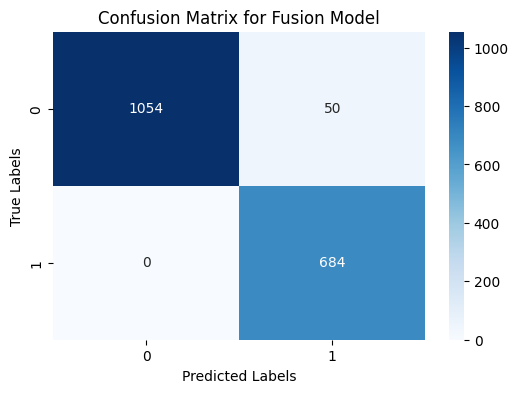

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
from google.colab import drive

drive.mount('/content/drive')

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    if len(parts) > 1:
        return int(parts[-1].replace('Subject', '').replace('subject', ''))
    else:
        return int(folder_name.replace('Subject', '').replace('subject', ''))

def load_images_and_labels(subjects, labels):
    images, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        subject_folder = str(subject_folder)
        for filename in os.listdir(subject_folder):
            img_path = os.path.join(subject_folder, str(filename))
            try:
                img = Image.open(img_path)
                width, height = img.size
                left, top, right, bottom = 100, 70, width - 200, height - 65
                img = img.crop((left, top, right, bottom))
                img = img.resize((299, 299))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}, {e}")
    return np.array(images), np.array(labels_t)

def load_and_preprocess_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    train_spectrogram_subjects, val_spectrogram_subjects, test_spectrogram_subjects = {}, {}, {}
    train_scalogram_subjects, val_scalogram_subjects, test_scalogram_subjects = {}, {}, {}
    ignore_subject = 'Subject_10'

    for spectrogram_subject_folder, spectrogram_label in zip(spectrogram_folders, spectrogram_labels):
        # if os.path.basename(spectrogram_subject_folder) == 'Subject10':
        #     continue
        spectrogram_subject_num = extract_numeric_part(os.path.basename(spectrogram_subject_folder))
        if 14 <= spectrogram_subject_num <= 16 or 55 <= spectrogram_subject_num <= 57:
            val_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        elif 17 <= spectrogram_subject_num <= 23 or 57 <= spectrogram_subject_num <= 62:
            test_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        else:
            train_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label

    for scalogram_subject_folder, scalogram_label in zip(scalogram_folders, scalogram_labels):
        # if os.path.basename(scalogram_subject_folder) == ignore_subject:
        #     continue
        scalogram_subject_num = extract_numeric_part(os.path.basename(scalogram_subject_folder))
        if 14 <= scalogram_subject_num <= 16 or 55 <= scalogram_subject_num <= 57:
            val_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        elif 17 <= scalogram_subject_num <= 23 or 57 <= scalogram_subject_num <= 62:
            test_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        else:
            train_scalogram_subjects[scalogram_subject_folder] = scalogram_label

    def split_data(data):
        subjects = list(data.keys())
        labels = [data[subj] for subj in subjects]
        images, labels_t = load_images_and_labels(subjects, labels)
        return images, np.array(labels_t)

    train_spectrogram_images, train_spectrogram_labels = split_data(train_spectrogram_subjects)
    val_spectrogram_images, val_spectrogram_labels = split_data(val_spectrogram_subjects)
    test_spectrogram_images, test_spectrogram_labels = split_data(test_spectrogram_subjects)

    train_scalogram_images, train_scalogram_labels = split_data(train_scalogram_subjects)
    val_scalogram_images, val_scalogram_labels = split_data(val_scalogram_subjects)
    test_scalogram_images, test_scalogram_labels = split_data(test_scalogram_subjects)

    return (
        train_spectrogram_images, train_spectrogram_labels,
        val_spectrogram_images, val_spectrogram_labels,
        test_spectrogram_images, test_spectrogram_labels,
        train_scalogram_images, train_scalogram_labels,
        val_scalogram_images, val_scalogram_labels,
        test_scalogram_images, test_scalogram_labels
    )

def load_and_rename_model(json_path, weights_path, prefix):
    with open(json_path, 'r') as json_file:
        json_model = json_file.read()
    model = model_from_json(json_model)
    model.load_weights(weights_path)

    for layer in model.layers:
        layer._name = prefix + layer.name
        layer.trainable = False

    return model

inception_spectrogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Spectrogram_iteration_2.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Spectrogram_best_weights_iteration_2.h5',
    'spectrogram_'
)

inception_scalogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Scalogram_iteration_2.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Scalogram_best_weights_iteration_2.h5',
    'scalogram_'
)

def create_fusion_model(spectrogram_model, scalogram_model):
    combined_input_spectrogram = spectrogram_model.input
    combined_input_scalogram = scalogram_model.input

    spectrogram_features = spectrogram_model.output
    scalogram_features = scalogram_model.output

    combined_features = Concatenate()([spectrogram_features, scalogram_features])
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[combined_input_spectrogram, combined_input_scalogram], outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

fusion_model = create_fusion_model(inception_spectrogram, inception_scalogram)
fusion_model.summary()

spectrogram_data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal'
scalogram_data_dir = '/content/Temporal'

def load_subjects_and_labels(data_dir, group_ranges):
    folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)
    subject_folders, labels = [], []
    for folder_name in folders:
        subject_num = extract_numeric_part(folder_name)
        subject_folder = os.path.join(data_dir, folder_name)
        subject_folders.append(subject_folder)
        if group_ranges[0] <= subject_num <= group_ranges[1]:
            labels.append(0)  # AD group
        elif group_ranges[2] <= subject_num <= group_ranges[3]:
            labels.append(1)  # HC group
    return np.array(subject_folders), np.array(labels)

Spectrogram_subject_folders, Spectrogram_labels = load_subjects_and_labels(spectrogram_data_dir, (1, 36, 37, 65))
Scalogram_subject_folders, Scalogram_labels = load_subjects_and_labels(scalogram_data_dir, (1, 36, 37, 65))

def ensure_matching_order(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    print(f"Spectrogram Folders length: {len(spectrogram_folders)}")
    print(f"Spectrogram Labels length: {len(spectrogram_labels)}")
    print(f"Scalogram Folders length: {len(scalogram_folders)}")
    print(f"Scalogram Labels length: {len(scalogram_labels)}")

    if len(scalogram_folders) == 0 or len(scalogram_labels) == 0:
        raise ValueError("Scalogram folders or labels array is empty.")

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in spectrogram_folders])
    spectrogram_folders = spectrogram_folders[sorted_indices]
    spectrogram_labels = spectrogram_labels[sorted_indices]

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in scalogram_folders])
    scalogram_folders = scalogram_folders[sorted_indices]
    scalogram_labels = scalogram_labels[sorted_indices]

    print(f"Sorted Spectrogram Folders: {spectrogram_folders}")
    print(f"Sorted Scalogram Folders: {scalogram_folders}")

    return spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels

Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels = ensure_matching_order(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

def load_combined_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    assert np.array_equal(spectrogram_labels, scalogram_labels), "Labels do not match."

    spectrogram_images, spectrogram_labels_t = load_images_and_labels(spectrogram_folders, spectrogram_labels)
    scalogram_images, scalogram_labels_t = load_images_and_labels(scalogram_folders, scalogram_labels)

    print(f"Spectrogram Labels: {spectrogram_labels_t}")
    print(f"Scalogram Labels: {scalogram_labels_t}")
    print(f"Spectrogram Images Shape: {spectrogram_images.shape}")
    print(f"Scalogram Images Shape: {scalogram_images.shape}")

    assert np.array_equal(spectrogram_labels_t, scalogram_labels_t), "Mismatch in loaded labels."

    return spectrogram_images, scalogram_images, spectrogram_labels_t

train_spectrogram_images, train_spectrogram_labels, val_spectrogram_images, val_spectrogram_labels, test_spectrogram_images, test_spectrogram_labels, train_scalogram_images, train_scalogram_labels, val_scalogram_images, val_scalogram_labels, test_scalogram_images, test_scalogram_labels = load_and_preprocess_data(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

checkpoint_dir = '/content'
os.makedirs(checkpoint_dir, exist_ok=True)
fusion_checkpoint_filepath = os.path.join(checkpoint_dir, "Fusion_Model_best_weights.h5")
fusion_drive_checkpoint_filepath = '/content/drive/My Drive/Fusion_Model_best_weights.h5'
fusion_checkpoint_callback = ModelCheckpoint(filepath=fusion_checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=False)

history = fusion_model.fit(
    [train_spectrogram_images, train_scalogram_images],
    train_spectrogram_labels,
    epochs=50,
    batch_size=32,
    validation_data=([val_spectrogram_images, val_scalogram_images], val_spectrogram_labels),
    callbacks=[fusion_checkpoint_callback, early_stopping],
    verbose=1
)

fusion_model_json = fusion_model.to_json()
with open("/content/drive/MyDrive/Fusion_Model.json", "w") as json_file:
    json_file.write(fusion_model_json)
fusion_model.save_weights(fusion_drive_checkpoint_filepath)

test_predictions = (fusion_model.predict([test_spectrogram_images, test_scalogram_images]) > 0.5).astype("int32")
accuracy = accuracy_score(test_spectrogram_labels, test_predictions)
precision = precision_score(test_spectrogram_labels, test_predictions)
recall = recall_score(test_spectrogram_labels, test_predictions)
f1 = f1_score(test_spectrogram_labels, test_predictions)

print(f"Fusion Model Test Accuracy: {accuracy:.4f}")
print(f"Fusion Model Test Precision: {precision:.4f}")
print(f"Fusion Model Test Recall: {recall:.4f}")
print(f"Fusion Model Test F1 Score: {f1:.4f}")

cm = confusion_matrix(test_spectrogram_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()


### Group 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spectrogram_input_1 (Input  [(None, 299, 299, 3)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 scalogram_input_1 (InputLa  [(None, 299, 299, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 spectrogram_conv2d (Conv2D  (None, 149, 149, 32)         864 

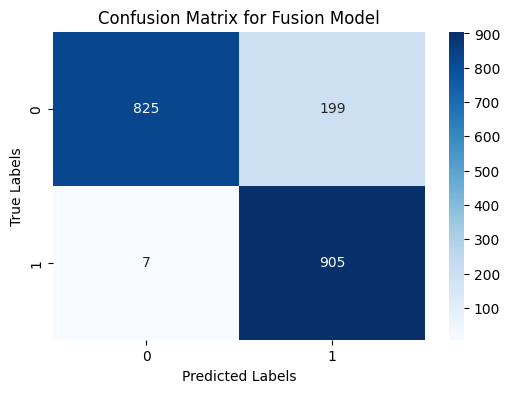

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
from google.colab import drive

drive.mount('/content/drive')

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    if len(parts) > 1:
        return int(parts[-1].replace('Subject', '').replace('subject', ''))
    else:
        return int(folder_name.replace('Subject', '').replace('subject', ''))

def load_images_and_labels(subjects, labels):
    images, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        subject_folder = str(subject_folder)
        for filename in os.listdir(subject_folder):
            img_path = os.path.join(subject_folder, str(filename))
            try:
                img = Image.open(img_path)
                width, height = img.size
                left, top, right, bottom = 100, 70, width - 200, height - 65
                img = img.crop((left, top, right, bottom))
                img = img.resize((299, 299))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}, {e}")
    return np.array(images), np.array(labels_t)

def load_and_preprocess_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    train_spectrogram_subjects, val_spectrogram_subjects, test_spectrogram_subjects = {}, {}, {}
    train_scalogram_subjects, val_scalogram_subjects, test_scalogram_subjects = {}, {}, {}
    ignore_subject = 'Subject_21'

    for spectrogram_subject_folder, spectrogram_label in zip(spectrogram_folders, spectrogram_labels):
        spectrogram_subject_num = extract_numeric_part(os.path.basename(spectrogram_subject_folder))
        if 16 <= spectrogram_subject_num <= 18 or 56 <= spectrogram_subject_num <= 58:
            val_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        elif 19 <= spectrogram_subject_num <= 25 or 59 <= spectrogram_subject_num <= 64:
            test_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        else:
            train_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label

    for scalogram_subject_folder, scalogram_label in zip(scalogram_folders, scalogram_labels):
        # if os.path.basename(scalogram_subject_folder) == ignore_subject:
        #     continue
        scalogram_subject_num = extract_numeric_part(os.path.basename(scalogram_subject_folder))
        if 16 <= scalogram_subject_num <= 18 or 56 <= scalogram_subject_num <= 58:
            val_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        elif 19 <= scalogram_subject_num <= 25 or 59 <= scalogram_subject_num <= 64:
            test_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        else:
            train_scalogram_subjects[scalogram_subject_folder] = scalogram_label

    def split_data(data):
        subjects = list(data.keys())
        labels = [data[subj] for subj in subjects]
        images, labels_t = load_images_and_labels(subjects, labels)
        return images, np.array(labels_t)

    train_spectrogram_images, train_spectrogram_labels = split_data(train_spectrogram_subjects)
    val_spectrogram_images, val_spectrogram_labels = split_data(val_spectrogram_subjects)
    test_spectrogram_images, test_spectrogram_labels = split_data(test_spectrogram_subjects)

    train_scalogram_images, train_scalogram_labels = split_data(train_scalogram_subjects)
    val_scalogram_images, val_scalogram_labels = split_data(val_scalogram_subjects)
    test_scalogram_images, test_scalogram_labels = split_data(test_scalogram_subjects)

    return (
        train_spectrogram_images, train_spectrogram_labels,
        val_spectrogram_images, val_spectrogram_labels,
        test_spectrogram_images, test_spectrogram_labels,
        train_scalogram_images, train_scalogram_labels,
        val_scalogram_images, val_scalogram_labels,
        test_scalogram_images, test_scalogram_labels
    )

def load_and_rename_model(json_path, weights_path, prefix):
    with open(json_path, 'r') as json_file:
        json_model = json_file.read()
    model = model_from_json(json_model)
    model.load_weights(weights_path)

    for layer in model.layers:
        layer._name = prefix + layer.name
        layer.trainable = False

    return model

inception_spectrogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Spectrogram_iteration_3.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Spectrogram_best_weights_iteration_3.h5',
    'spectrogram_'
)

inception_scalogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Scalogram_iteration_3.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Temporal_Scalogram_best_weights_iteration_3.h5',
    'scalogram_'
)

def create_fusion_model(spectrogram_model, scalogram_model):
    combined_input_spectrogram = spectrogram_model.input
    combined_input_scalogram = scalogram_model.input

    spectrogram_features = spectrogram_model.output
    scalogram_features = scalogram_model.output

    combined_features = Concatenate()([spectrogram_features, scalogram_features])
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[combined_input_spectrogram, combined_input_scalogram], outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

fusion_model = create_fusion_model(inception_spectrogram, inception_scalogram)
fusion_model.summary()

spectrogram_data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Temporal'
scalogram_data_dir = '/content/Temporal'

def load_subjects_and_labels(data_dir, group_ranges):
    folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)
    subject_folders, labels = [], []
    for folder_name in folders:
        subject_num = extract_numeric_part(folder_name)
        subject_folder = os.path.join(data_dir, folder_name)
        subject_folders.append(subject_folder)
        if group_ranges[0] <= subject_num <= group_ranges[1]:
            labels.append(0)  # AD group
        elif group_ranges[2] <= subject_num <= group_ranges[3]:
            labels.append(1)  # HC group
    return np.array(subject_folders), np.array(labels)

Spectrogram_subject_folders, Spectrogram_labels = load_subjects_and_labels(spectrogram_data_dir, (1, 36, 37, 65))
Scalogram_subject_folders, Scalogram_labels = load_subjects_and_labels(scalogram_data_dir, (1, 36, 37, 65))

def ensure_matching_order(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    print(f"Spectrogram Folders length: {len(spectrogram_folders)}")
    print(f"Spectrogram Labels length: {len(spectrogram_labels)}")
    print(f"Scalogram Folders length: {len(scalogram_folders)}")
    print(f"Scalogram Labels length: {len(scalogram_labels)}")

    if len(scalogram_folders) == 0 or len(scalogram_labels) == 0:
        raise ValueError("Scalogram folders or labels array is empty.")

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in spectrogram_folders])
    spectrogram_folders = spectrogram_folders[sorted_indices]
    spectrogram_labels = spectrogram_labels[sorted_indices]

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in scalogram_folders])
    scalogram_folders = scalogram_folders[sorted_indices]
    scalogram_labels = scalogram_labels[sorted_indices]

    print(f"Sorted Spectrogram Folders: {spectrogram_folders}")
    print(f"Sorted Scalogram Folders: {scalogram_folders}")

    return spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels

Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels = ensure_matching_order(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

def load_combined_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    assert np.array_equal(spectrogram_labels, scalogram_labels), "Labels do not match."

    spectrogram_images, spectrogram_labels_t = load_images_and_labels(spectrogram_folders, spectrogram_labels)
    scalogram_images, scalogram_labels_t = load_images_and_labels(scalogram_folders, scalogram_labels)

    print(f"Spectrogram Labels: {spectrogram_labels_t}")
    print(f"Scalogram Labels: {scalogram_labels_t}")
    print(f"Spectrogram Images Shape: {spectrogram_images.shape}")
    print(f"Scalogram Images Shape: {scalogram_images.shape}")

    assert np.array_equal(spectrogram_labels_t, scalogram_labels_t), "Mismatch in loaded labels."

    return spectrogram_images, scalogram_images, spectrogram_labels_t

train_spectrogram_images, train_spectrogram_labels, val_spectrogram_images, val_spectrogram_labels, test_spectrogram_images, test_spectrogram_labels, train_scalogram_images, train_scalogram_labels, val_scalogram_images, val_scalogram_labels, test_scalogram_images, test_scalogram_labels = load_and_preprocess_data(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

checkpoint_dir = '/content'
os.makedirs(checkpoint_dir, exist_ok=True)
fusion_checkpoint_filepath = os.path.join(checkpoint_dir, "Fusion_Model_best_weights.h5")
fusion_drive_checkpoint_filepath = '/content/drive/My Drive/Fusion_Model_best_weights.h5'
fusion_checkpoint_callback = ModelCheckpoint(filepath=fusion_checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=False)

history = fusion_model.fit(
    [train_spectrogram_images, train_scalogram_images],
    train_spectrogram_labels,
    epochs=50,
    batch_size=32,
    validation_data=([val_spectrogram_images, val_scalogram_images], val_spectrogram_labels),
    callbacks=[fusion_checkpoint_callback, early_stopping],
    verbose=1
)

fusion_model_json = fusion_model.to_json()
with open("/content/drive/MyDrive/Fusion_Model.json", "w") as json_file:
    json_file.write(fusion_model_json)
fusion_model.save_weights(fusion_drive_checkpoint_filepath)

test_predictions = (fusion_model.predict([test_spectrogram_images, test_scalogram_images]) > 0.5).astype("int32")
accuracy = accuracy_score(test_spectrogram_labels, test_predictions)
precision = precision_score(test_spectrogram_labels, test_predictions)
recall = recall_score(test_spectrogram_labels, test_predictions)
f1 = f1_score(test_spectrogram_labels, test_predictions)

print(f"Fusion Model Test Accuracy: {accuracy:.4f}")
print(f"Fusion Model Test Precision: {precision:.4f}")
print(f"Fusion Model Test Recall: {recall:.4f}")
print(f"Fusion Model Test F1 Score: {f1:.4f}")

cm = confusion_matrix(test_spectrogram_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()


## Use pretrained weights: Parietal

In [ ]:
data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal'

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    for part in parts:
        if part.startswith('subject'):
            return int(part.replace('subject', ''))
    return -1  # Return -1 if no numeric part is found

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

Spectrogram_subject_folders, Spectrogram_labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    Spectrogram_subject_folder = os.path.join(data_dir, folder_name)
    Spectrogram_subject_folders.append(Spectrogram_subject_folder)

    if subject_num <= 36:
        Spectrogram_labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        Spectrogram_labels.append(1)  # HC group

Spectrogram_subject_folders = np.array(Spectrogram_subject_folders)
Spectrogram_labels = np.array(Spectrogram_labels)

print("Spectrogram Subject Folders:", Spectrogram_subject_folders)
print("Labels:", Spectrogram_labels)

Spectrogram Subject Folders: ['/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject1'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject2'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject3'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject4'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject5'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject6'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject7'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject8'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal/subject9'
 '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/

In [ ]:
# data_dir = '/content/drive/MyDrive/Alzheimer/Scalogram Images/Parietal/'
!unrar x '/content/drive/MyDrive/Alzheimer/Final_1Hz/Parietal.rar'
data_dir = '/content/Parietal'
def extract_numeric_part(folder_name):
    return int(folder_name.split('_')[-1])

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

Scalogram_subject_folders, Scalogram_labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    Scalogram_subject_folder = os.path.join(data_dir, folder_name)
    Scalogram_subject_folders.append(Scalogram_subject_folder)

    if subject_num <= 36:
        Scalogram_labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        Scalogram_labels.append(1)  # HC group

Scalogram_subject_folders = np.array(Scalogram_subject_folders)
Scalogram_labels = np.array(Scalogram_labels)

print("Scalogram Subject Folders:", Scalogram_subject_folders)
print("Labels:", Scalogram_labels)

Streaming output truncated to the last 5000 lines.
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_45.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_46.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_47.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_48.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_49.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_5.jpg          35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_50.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_51.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_52.jpg         35%  OK 
Extracting  Parietal/Subject_31/Subject_31_Channel_7_Epoch_53.jpg         35%  OK 
Extracting  Parietal/Subject_

### Group 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spectrogram_input_2 (Input  [(None, 299, 299, 3)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 scalogram_input_2 (InputLa  [(None, 299, 299, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 spectrogram_conv2d_94 (Con  (None, 149, 149, 32)         864 

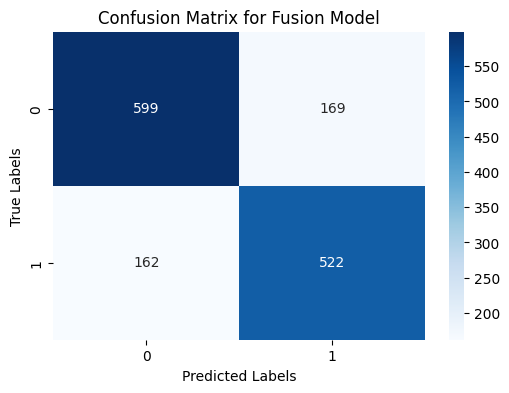

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
from google.colab import drive

drive.mount('/content/drive')

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    if len(parts) > 1:
        return int(parts[-1].replace('Subject', '').replace('subject', ''))
    else:
        return int(folder_name.replace('Subject', '').replace('subject', ''))

def load_images_and_labels(subjects, labels):
    images, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        subject_folder = str(subject_folder)
        for filename in os.listdir(subject_folder):
            img_path = os.path.join(subject_folder, str(filename))
            try:
                img = Image.open(img_path)
                width, height = img.size
                left, top, right, bottom = 100, 70, width - 200, height - 65
                img = img.crop((left, top, right, bottom))
                img = img.resize((299, 299))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}, {e}")
    return np.array(images), np.array(labels_t)

def load_and_preprocess_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    train_spectrogram_subjects, val_spectrogram_subjects, test_spectrogram_subjects = {}, {}, {}
    train_scalogram_subjects, val_scalogram_subjects, test_scalogram_subjects = {}, {}, {}
    ignore_subject = 'Subject_21'

    for spectrogram_subject_folder, spectrogram_label in zip(spectrogram_folders, spectrogram_labels):
        spectrogram_subject_num = extract_numeric_part(os.path.basename(spectrogram_subject_folder))
        if 16 <= spectrogram_subject_num <= 18 or 56 <= spectrogram_subject_num <= 58:
            val_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        elif 19 <= spectrogram_subject_num <= 25 or 59 <= spectrogram_subject_num <= 64:
            test_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label
        else:
            train_spectrogram_subjects[spectrogram_subject_folder] = spectrogram_label

    for scalogram_subject_folder, scalogram_label in zip(scalogram_folders, scalogram_labels):
        # if os.path.basename(scalogram_subject_folder) == ignore_subject:
        #     continue
        scalogram_subject_num = extract_numeric_part(os.path.basename(scalogram_subject_folder))
        if 16 <= scalogram_subject_num <= 18 or 56 <= scalogram_subject_num <= 58:
            val_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        elif 19 <= scalogram_subject_num <= 25 or 59 <= scalogram_subject_num <= 64:
            test_scalogram_subjects[scalogram_subject_folder] = scalogram_label
        else:
            train_scalogram_subjects[scalogram_subject_folder] = scalogram_label

    def split_data(data):
        subjects = list(data.keys())
        labels = [data[subj] for subj in subjects]
        images, labels_t = load_images_and_labels(subjects, labels)
        return images, np.array(labels_t)

    train_spectrogram_images, train_spectrogram_labels = split_data(train_spectrogram_subjects)
    val_spectrogram_images, val_spectrogram_labels = split_data(val_spectrogram_subjects)
    test_spectrogram_images, test_spectrogram_labels = split_data(test_spectrogram_subjects)

    train_scalogram_images, train_scalogram_labels = split_data(train_scalogram_subjects)
    val_scalogram_images, val_scalogram_labels = split_data(val_scalogram_subjects)
    test_scalogram_images, test_scalogram_labels = split_data(test_scalogram_subjects)

    return (
        train_spectrogram_images, train_spectrogram_labels,
        val_spectrogram_images, val_spectrogram_labels,
        test_spectrogram_images, test_spectrogram_labels,
        train_scalogram_images, train_scalogram_labels,
        val_scalogram_images, val_scalogram_labels,
        test_scalogram_images, test_scalogram_labels
    )

def load_and_rename_model(json_path, weights_path, prefix):
    with open(json_path, 'r') as json_file:
        json_model = json_file.read()
    model = model_from_json(json_model)
    model.load_weights(weights_path)

    for layer in model.layers:
        layer._name = prefix + layer.name
        layer.trainable = False

    return model

inception_spectrogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Parietal_Spectrogram_iteration_1.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Parietal_Spectrogram_best_weights_iteration_1.h5',
    'spectrogram_'
)

inception_scalogram = load_and_rename_model(
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Parietal_Scalogram_iteration_1.json',
    '/content/drive/MyDrive/Alzheimer/InceptionV3_Parietal_Scalogram_best_weights_iteration_1.h5',
    'scalogram_'
)

def create_fusion_model(spectrogram_model, scalogram_model):
    combined_input_spectrogram = spectrogram_model.input
    combined_input_scalogram = scalogram_model.input

    spectrogram_features = spectrogram_model.output
    scalogram_features = scalogram_model.output

    combined_features = Concatenate()([spectrogram_features, scalogram_features])
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[combined_input_spectrogram, combined_input_scalogram], outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

fusion_model = create_fusion_model(inception_spectrogram, inception_scalogram)
fusion_model.summary()

spectrogram_data_dir = '/content/drive/MyDrive/Alzheimer/Spectrogram Images/Spectrogram_Images_output/Parietal'
scalogram_data_dir = '/content/Parietal'

def load_subjects_and_labels(data_dir, group_ranges):
    folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)
    subject_folders, labels = [], []
    for folder_name in folders:
        subject_num = extract_numeric_part(folder_name)
        subject_folder = os.path.join(data_dir, folder_name)
        subject_folders.append(subject_folder)
        if group_ranges[0] <= subject_num <= group_ranges[1]:
            labels.append(0)  # AD group
        elif group_ranges[2] <= subject_num <= group_ranges[3]:
            labels.append(1)  # HC group
    return np.array(subject_folders), np.array(labels)

Spectrogram_subject_folders, Spectrogram_labels = load_subjects_and_labels(spectrogram_data_dir, (1, 36, 37, 65))
Scalogram_subject_folders, Scalogram_labels = load_subjects_and_labels(scalogram_data_dir, (1, 36, 37, 65))

def ensure_matching_order(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    print(f"Spectrogram Folders length: {len(spectrogram_folders)}")
    print(f"Spectrogram Labels length: {len(spectrogram_labels)}")
    print(f"Scalogram Folders length: {len(scalogram_folders)}")
    print(f"Scalogram Labels length: {len(scalogram_labels)}")

    if len(scalogram_folders) == 0 or len(scalogram_labels) == 0:
        raise ValueError("Scalogram folders or labels array is empty.")

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in spectrogram_folders])
    spectrogram_folders = spectrogram_folders[sorted_indices]
    spectrogram_labels = spectrogram_labels[sorted_indices]

    sorted_indices = np.argsort([extract_numeric_part(os.path.basename(folder)) for folder in scalogram_folders])
    scalogram_folders = scalogram_folders[sorted_indices]
    scalogram_labels = scalogram_labels[sorted_indices]

    print(f"Sorted Spectrogram Folders: {spectrogram_folders}")
    print(f"Sorted Scalogram Folders: {scalogram_folders}")

    return spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels

Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels = ensure_matching_order(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

def load_combined_data(spectrogram_folders, spectrogram_labels, scalogram_folders, scalogram_labels):
    assert np.array_equal(spectrogram_labels, scalogram_labels), "Labels do not match."

    spectrogram_images, spectrogram_labels_t = load_images_and_labels(spectrogram_folders, spectrogram_labels)
    scalogram_images, scalogram_labels_t = load_images_and_labels(scalogram_folders, scalogram_labels)

    print(f"Spectrogram Labels: {spectrogram_labels_t}")
    print(f"Scalogram Labels: {scalogram_labels_t}")
    print(f"Spectrogram Images Shape: {spectrogram_images.shape}")
    print(f"Scalogram Images Shape: {scalogram_images.shape}")

    assert np.array_equal(spectrogram_labels_t, scalogram_labels_t), "Mismatch in loaded labels."

    return spectrogram_images, scalogram_images, spectrogram_labels_t

train_spectrogram_images, train_spectrogram_labels, val_spectrogram_images, val_spectrogram_labels, test_spectrogram_images, test_spectrogram_labels, train_scalogram_images, train_scalogram_labels, val_scalogram_images, val_scalogram_labels, test_scalogram_images, test_scalogram_labels = load_and_preprocess_data(
    Spectrogram_subject_folders, Spectrogram_labels, Scalogram_subject_folders, Scalogram_labels
)

checkpoint_dir = '/content'
os.makedirs(checkpoint_dir, exist_ok=True)
fusion_checkpoint_filepath = os.path.join(checkpoint_dir, "Fusion_Model_best_weights.h5")
fusion_drive_checkpoint_filepath = '/content/drive/My Drive/Fusion_Model_best_weights.h5'
fusion_checkpoint_callback = ModelCheckpoint(filepath=fusion_checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=False)

history = fusion_model.fit(
    [train_spectrogram_images, train_scalogram_images],
    train_spectrogram_labels,
    epochs=50,
    batch_size=32,
    validation_data=([val_spectrogram_images, val_scalogram_images], val_spectrogram_labels),
    callbacks=[fusion_checkpoint_callback, early_stopping],
    verbose=1
)

fusion_model_json = fusion_model.to_json()
with open("/content/drive/MyDrive/Fusion_Model.json", "w") as json_file:
    json_file.write(fusion_model_json)
fusion_model.save_weights(fusion_drive_checkpoint_filepath)

test_predictions = (fusion_model.predict([test_spectrogram_images, test_scalogram_images]) > 0.5).astype("int32")
accuracy = accuracy_score(test_spectrogram_labels, test_predictions)
precision = precision_score(test_spectrogram_labels, test_predictions)
recall = recall_score(test_spectrogram_labels, test_predictions)
f1 = f1_score(test_spectrogram_labels, test_predictions)

print(f"Fusion Model Test Accuracy: {accuracy:.4f}")
print(f"Fusion Model Test Precision: {precision:.4f}")
print(f"Fusion Model Test Recall: {recall:.4f}")
print(f"Fusion Model Test F1 Score: {f1:.4f}")

cm = confusion_matrix(test_spectrogram_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()
